# Analizando Documentos sobre COVID-19

En este desafío, continuaremos con el tema de la pandemia de COVID y nos enfocaremos en procesar documentos científicos sobre el tema. Existe el [Dataset CORD-19](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) con más de 7000 (en el momento de escribir esto) documentos sobre COVID, disponible con metadatos y resúmenes (y para aproximadamente la mitad de ellos también se proporciona el texto completo).

Un ejemplo completo de análisis de este conjunto de datos utilizando el servicio cognitivo [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) se describe [en este artículo de blog](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Discutiremos una versión simplificada de este análisis.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Obteniendo los Datos

Primero, necesitamos obtener los metadatos de los artículos de CORD con los que vamos a trabajar.

**NOTA**: No proporcionamos una copia del conjunto de datos como parte de este repositorio. Es posible que primero necesites descargar el archivo [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) desde [este conjunto de datos en Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Puede que se requiera registrarse en Kaggle. También puedes descargar el conjunto de datos sin registrarte [desde aquí](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), pero incluirá todos los textos completos además del archivo de metadatos.

Intentaremos obtener los datos directamente desde la fuente en línea, sin embargo, si esto falla, necesitarás descargar los datos como se describió anteriormente. Además, tiene sentido descargar los datos si planeas experimentar con ellos más adelante, para ahorrar tiempo de espera.

> **NOTA** que el conjunto de datos es bastante grande, alrededor de 1 Gb de tamaño, ¡y la siguiente línea de código puede tardar mucho en completarse! (~5 minutos)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Ahora convertiremos la columna de fecha de publicación a `datetime` y trazaremos el histograma para ver el rango de fechas de publicación.


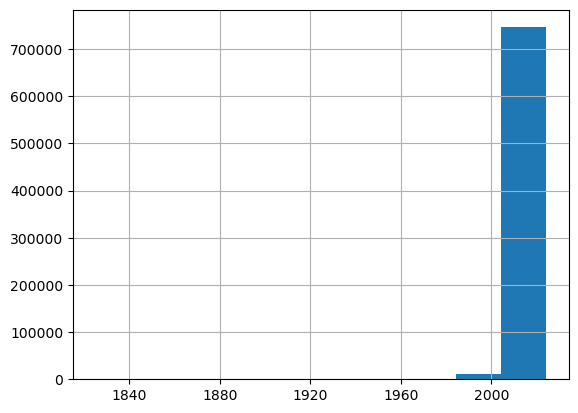

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Extracción de Datos Estructurados

Veamos qué tipo de información podemos extraer fácilmente de los resúmenes. Una cosa que podría interesarnos es identificar qué estrategias de tratamiento existen y cómo han evolucionado con el tiempo. Para empezar, podemos compilar manualmente la lista de posibles medicamentos utilizados para tratar el COVID, así como la lista de diagnósticos. Luego, revisamos estas listas y buscamos los términos correspondientes en los resúmenes de los artículos.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Hemos añadido varias columnas a nuestro dataframe que contienen el número de veces que un medicamento o diagnóstico específico aparece en el resumen.

> **Nota** que añadimos un espacio al principio de la palabra al buscar una subcadena. Si no hacemos esto, podríamos obtener resultados incorrectos, porque *chloroquine* también se encontraría dentro de la subcadena *hydroxychloroquine*. Además, forzamos la conversión de la columna de resúmenes a `str` para evitar un error; intenta eliminar `str` y observa qué sucede.

Para facilitar el trabajo con los datos, podemos extraer un sub-marco que contenga únicamente los conteos de medicamentos y calcular el número acumulado de ocurrencias. Esto nos da el medicamento más popular:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

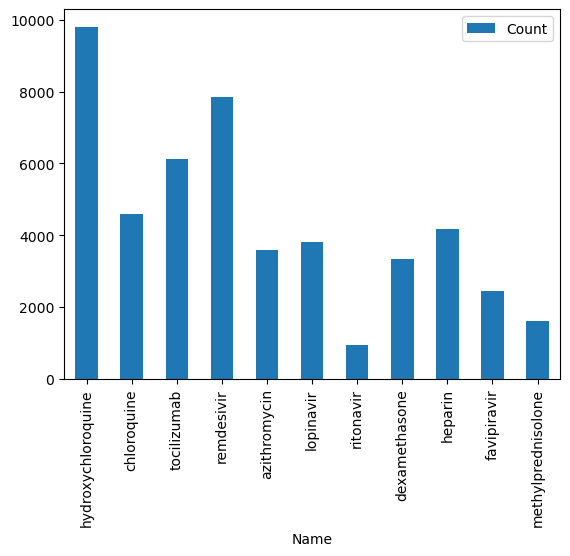

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Buscando Tendencias en Estrategias de Tratamiento

En el ejemplo anterior hemos `sum`ado todos los valores, pero también podemos hacerlo de forma mensual:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

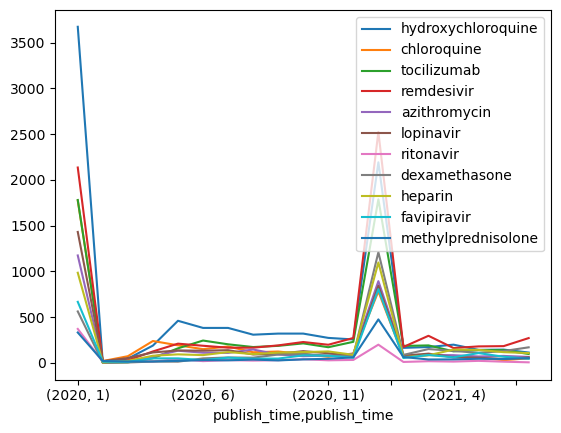

In [152]:
dfmt.plot()
plt.show()

Una observación interesante es que tenemos picos enormes en dos ubicaciones: enero de 2020 y enero de 2021. Esto se debe al hecho de que algunos artículos no tienen una fecha de publicación claramente especificada, y se asignan como enero del año correspondiente.

Para entender mejor los datos, vamos a visualizar solo unos pocos medicamentos. También "eliminaremos" los datos de enero y los reemplazaremos con algún valor medio, para obtener un gráfico más agradable:


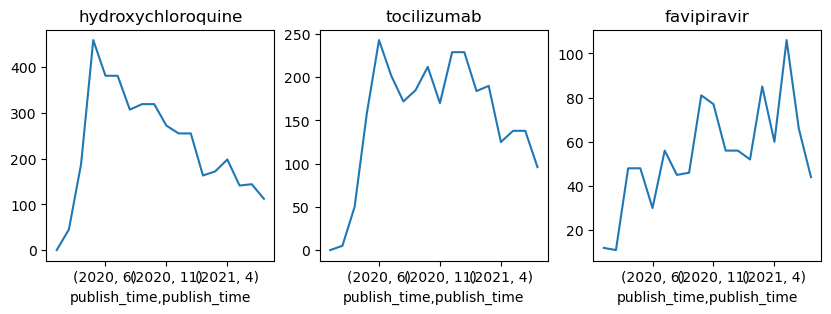

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

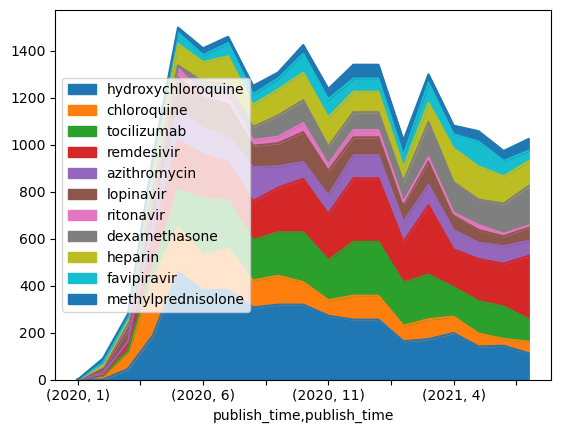

In [154]:
dfmt.plot.area()
plt.show()

Incluso más allá, podemos calcular la popularidad relativa en porcentajes:


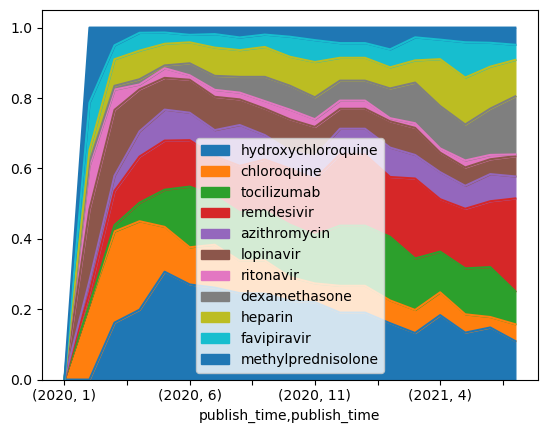

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Correspondencia entre Medicinas y Diagnósticos

Una de las relaciones más interesantes que podemos explorar es cómo diferentes diagnósticos se tratan con diferentes medicinas. Para visualizar esto, necesitamos calcular un **mapa de frecuencia de co-ocurrencia**, que mostrará cuántas veces dos términos se mencionan en el mismo artículo.

Este mapa es esencialmente una matriz 2D, que se representa mejor mediante un **numpy array**. Calcularemos este mapa recorriendo todos los resúmenes y marcando las entidades que aparecen allí:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Una de las formas de visualizar esta matriz es dibujar un **mapa de calor**:


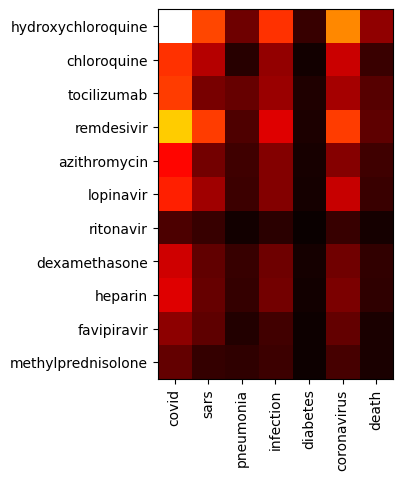

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

¡Sin duda, una mejor visualización se puede lograr utilizando el llamado diagrama **Sankey**! `matplotlib` no tiene soporte integrado para este tipo de diagrama, por lo que tendríamos que usar [Plotly](https://plotly.com/python/) como se describe [en este tutorial](https://plotly.com/python/sankey-diagram/).

Para crear un diagrama Sankey con Plotly, necesitamos construir las siguientes listas:
* La lista `all_nodes` con todos los nodos del gráfico, que incluirá tanto medicamentos como diagnósticos.
* Una lista de índices de origen y destino: estas listas mostrarán qué nodos van hacia la izquierda y cuáles hacia la derecha en el diagrama.
* Una lista de todos los enlaces, donde cada enlace consta de:
   - El índice de origen en el array `all_nodes`.
   - El índice de destino.
   - Un valor que indica la fuerza del enlace. Este es exactamente el valor de nuestra matriz de co-ocurrencia.
   - Opcionalmente, el color del enlace. Haremos una opción para resaltar algunos de los términos para mayor claridad.

El código genérico para dibujar un diagrama Sankey está estructurado como una función separada llamada `sankey`, que toma dos listas (categorías de origen y destino) y la matriz de co-ocurrencia. También nos permite especificar un umbral y omitir todos los enlaces que sean más débiles que ese umbral, lo que hace que el diagrama sea un poco menos complejo.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Conclusión

Has visto que podemos usar métodos bastante simples para extraer información de fuentes de datos no estructuradas, como el texto. En este ejemplo, hemos utilizado la lista existente de medicamentos, pero sería mucho más poderoso emplear técnicas de procesamiento de lenguaje natural (NLP) para realizar la extracción de entidades desde texto. En [este artículo del blog](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) describimos cómo usar servicios en la nube para la extracción de entidades. Otra opción sería utilizar bibliotecas de NLP en Python como [NLTK](https://www.nltk.org/) - un enfoque para extraer información de texto usando NLTK se describe [aquí](https://www.nltk.org/book/ch07.html).


## Desafío

Continúa investigando los datos de los artículos sobre COVID en las siguientes líneas:

1. Construye una matriz de co-ocurrencia de diferentes medicamentos y observa qué medicamentos suelen aparecer juntos (es decir, mencionados en un mismo resumen). Puedes modificar el código para construir la matriz de co-ocurrencia de medicamentos y diagnósticos.
1. Visualiza esta matriz utilizando un mapa de calor.
1. Como un objetivo adicional, podrías visualizar la co-ocurrencia de medicamentos utilizando un [diagrama de cuerdas](https://en.wikipedia.org/wiki/Chord_diagram). [Esta biblioteca](https://pypi.org/project/chord/) puede ayudarte a dibujar un diagrama de cuerdas.
1. Como otro objetivo adicional, intenta extraer las dosis de diferentes medicamentos (como **400mg** en *tomar 400mg de cloroquina diariamente*) utilizando expresiones regulares, y construye un dataframe que muestre las diferentes dosis para distintos medicamentos. **Nota**: considera los valores numéricos que estén en proximidad textual cercana al nombre del medicamento.



---

**Descargo de responsabilidad**:  
Este documento ha sido traducido utilizando el servicio de traducción automática [Co-op Translator](https://github.com/Azure/co-op-translator). Si bien nos esforzamos por garantizar la precisión, tenga en cuenta que las traducciones automatizadas pueden contener errores o imprecisiones. El documento original en su idioma nativo debe considerarse la fuente autorizada. Para información crítica, se recomienda una traducción profesional realizada por humanos. No nos hacemos responsables de malentendidos o interpretaciones erróneas que puedan surgir del uso de esta traducción.
